# Classification of White blood cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

Classification of Human White Blood Cells Using Machine Learning for Stain-Free Imaging Flow Cytometry https://doi.org/10.1002/cyto.a.23920


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

In [1]:
!pip -q install /pstore/home/shetabs1/code/MarrLab/scifAI/

You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


here we import a series of needed modules. 

In [2]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [3]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [4]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [45]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [6]:
%%time

data_path = "/pstore/data/DS4/White_blood_cell_dataset/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:09<00:00, 3324.77it/s]


...metadata prepration ended.
CPU times: user 479 ms, sys: 245 ms, total: 724 ms
Wall time: 9.99 s


In [7]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,26659,labeled,CD15+ neutrophil
1,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30716,labeled,CD15+ neutrophil
2,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30519,labeled,CD14+ monocyte
3,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,CD15+ neutrophil
4,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,17483,labeled,CD15+ neutrophil
...,...,...,...,...,...,...,...
31275,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,25994,labeled,CD15+ neutrophil
31276,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,CD8+ T
31277,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,29508,labeled,CD14+ monocyte
31278,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,23111,labeled,CD4+ T


['CD15+ neutrophil' 'CD14+ monocyte' 'eosinophil' 'unknown' 'CD4+ T'
 'CD56+ NK' 'NKT' 'CD8+ T' 'CD19+ B']


<AxesSubplot:>

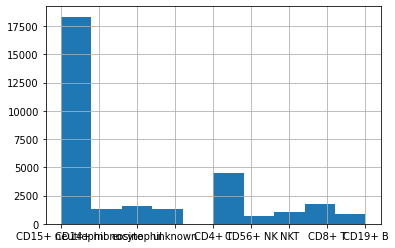

In [8]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [9]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

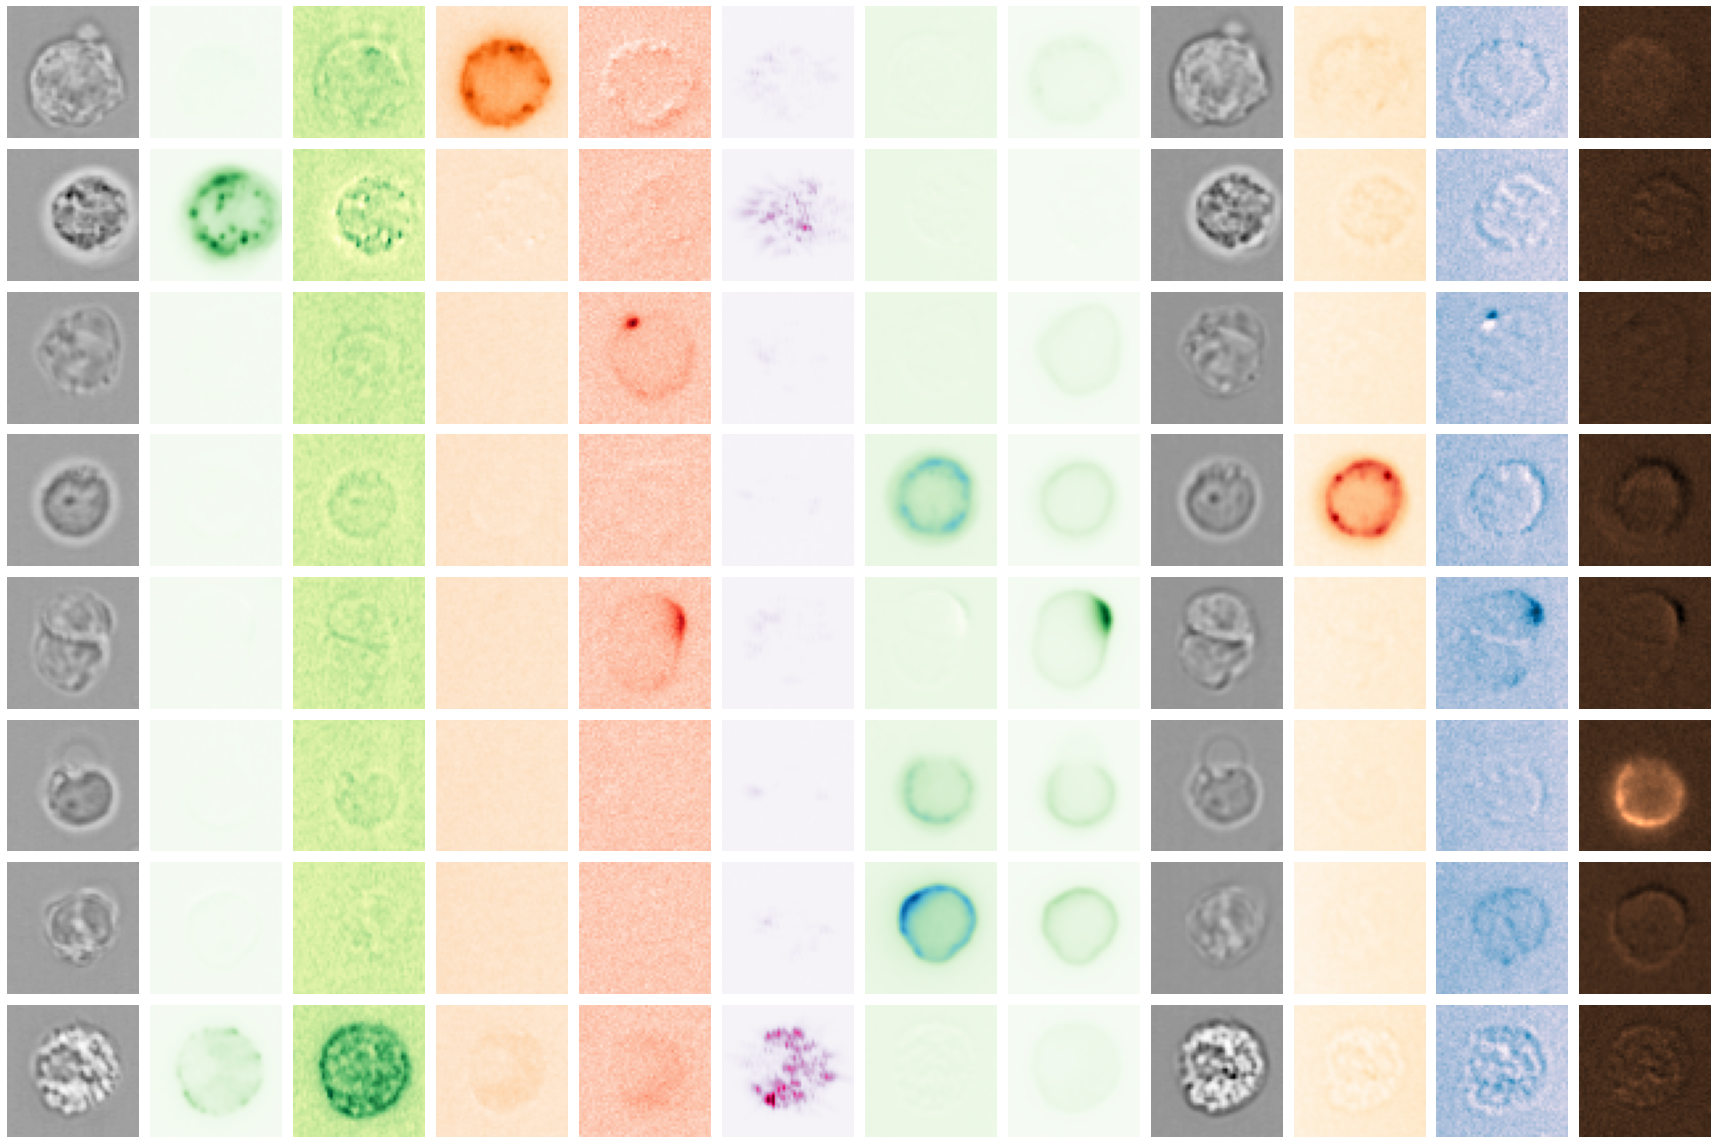

In [10]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1)).reset_index(drop = True) ,  
                              figsize = None,
                    channel_colors =  ["Greys", "Greens","YlGn", "Oranges", "Reds", "PuRd","GnBu","Greens","Greys","OrRd","PuBu","copper"],
                    image_size = 50)

Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

Define all necessary parameters

In [12]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 64
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]


In [13]:

selected_channels = np.arange(12)
num_channels = len(selected_channels)
channels =np.asarray([ "Ch" + str(i) for i in selected_channels])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [14]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [15]:
train_index, validation_index, test_index = train_validation_test_split(metadata.index, 
                                                                        metadata["label"], 
                                                                        random_state=seed_value)

In [16]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'CD14+ monocyte': 0,
 'CD15+ neutrophil': 1,
 'CD19+ B': 2,
 'CD4+ T': 3,
 'CD56+ NK': 4,
 'CD8+ T': 5,
 'NKT': 6,
 'eosinophil': 7}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [17]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

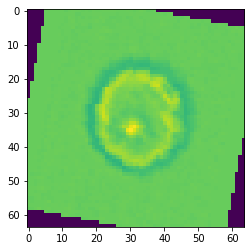

In [19]:
plt.imshow(train_dataset[0][0][0])

In [20]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 150/150 [05:03<00:00,  2.03s/it]

statistics used: {'min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p25': tensor([0.1920, 0.0032, 0.0139, 0.0049, 0.0071, 0.0090, 0.0103, 0.0079, 0.1888,
        0.0120, 0.0046, 0.0082]), 'p50': tensor([0.1966, 0.0040, 0.0144, 0.0051, 0.0076, 0.0098, 0.0110, 0.0083, 0.1921,
        0.0131, 0.0056, 0.0085]), 'p75': tensor([0.1979, 0.0089, 0.0147, 0.0056, 0.0078, 0.0131, 0.0117, 0.0101, 0.1936,
        0.0141, 0.0063, 0.0088]), 'p95': tensor([0.2090, 0.0660, 0.0156, 0.0061, 0.0083, 0.0497, 0.0273, 0.0245, 0.2050,
        0.0161, 0.0073, 0.0095]), 'p99': tensor([0.2318, 0.1183, 0.0182, 0.0096, 0.0090, 0.1032, 0.0708, 0.0416, 0.2274,
        0.0276, 0.0082, 0.0144]), 'max': tensor([0.3582, 0.8967, 0.0531, 0.0337, 0.0218, 0.7936, 0.2970, 0.1337, 0.3641,
        0.0946, 0.0268, 0.0743]), 'mean': tensor([0.1729, 0.0139, 0.0128, 0.0048, 0.0067, 0.015

adding the normalization to each transform

In [21]:
train_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

test_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [22]:
train_loader = None

defining train, validation and test datasets

In [23]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [24]:
import torch.nn as nn
from torchvision.models import resnet18
import torch.nn.functional as F

class ResNet18Modified(nn.Module):
    def __init__(self,  num_channels=3, num_classes=3, pretrained=True, progress=True, **kwargs):
        super().__init__()
        model = resnet18(pretrained=pretrained)
        if num_channels != 3:
            model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = model

    def forward(self, x):                
        return self.model(x)

resnet18_modified = ResNet18Modified(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

In [25]:
resnet18_modified

ResNet18Modified(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [26]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=20, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

lets define and train the model using `skorch`

In [28]:
model = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.AdamW,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [29]:
model = model.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        0.6327       0.8766            0.5637        0.2981  38.0536
      2        0.1172       0.9737            0.9040        0.0699  35.3353
      3        0.0650       0.9829            0.9385        0.0643  35.4055
      4        0.0591       0.9925            0.9769        0.0345  35.5408
      5        0.0374       0.9840            0.9485        0.0763  35.2372
      6        0.0443       0.9800            0.9426        0.0722  35.1183


we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

In [46]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = model.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      1.00       205
CD15+ neutrophil       1.00      1.00      1.00      2932
         CD19+ B       0.99      1.00      1.00       142
          CD4+ T       0.99      1.00      1.00       716
        CD56+ NK       1.00      0.97      0.99       107
          CD8+ T       1.00      0.34      0.51       286
             NKT       0.45      0.96      0.61       165
      eosinophil       1.00      0.98      0.99       246

        accuracy                           0.96      4799
       macro avg       0.93      0.91      0.89      4799
    weighted avg       0.98      0.96      0.95      4799

------------------------------------------------------------
matthews correlation coeff: 0.93
Cohen Kappa score: 0.93
Accuracy: 0.96 & balanced Accuracy: 0.91
macro F1 score: 0.89 & micro F1 score: 0.96
macro Precision score: 0.93 & micro Precision score: 0.96
macro Recall score: 0.91 & micro Recall 

and finally for the test set

In [47]:
preds = model.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      0.99      0.99       256
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       0.98      1.00      0.99       178
          CD4+ T       0.99      1.00      0.99       895
        CD56+ NK       0.98      0.97      0.98       134
          CD8+ T       1.00      0.33      0.50       358
             NKT       0.44      0.93      0.60       206
      eosinophil       0.99      0.98      0.99       307

        accuracy                           0.95      5999
       macro avg       0.92      0.90      0.88      5999
    weighted avg       0.98      0.95      0.95      5999

------------------------------------------------------------
matthews correlation coeff: 0.93
Cohen Kappa score: 0.92
Accuracy: 0.95 & balanced Accuracy: 0.90
macro F1 score: 0.88 & micro F1 score: 0.95
macro Precision score: 0.92 & micro Precision score: 0.95
macro Recall score: 0.90 & micro Recall 